# Clasificación de imágenes de personas con mascarilla


## 1. Importación de librerías

In [39]:
# General
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# Keras
import keras
from keras.src.utils import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Input

from keras.models import Sequential, Model
from keras.utils import to_categorical

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

## 2. Creación de dataframe y partición en train y test


In [40]:
# Cargar datos de entrenamiento
train_dataset = image_dataset_from_directory(
    directory='./train',
    image_size=(128, 128),
    labels='inferred',
    label_mode='binary',
    class_names=['mascarilla', 'no_mascarilla'],
    subset='training',
    validation_split=0.2,
    seed=123
)

# Cargar datos de validación
val_dataset = image_dataset_from_directory(
    directory='./train',
    image_size=(128, 128),
    labels='inferred',
    label_mode='binary',
    class_names=['mascarilla', 'no_mascarilla'],
    subset='validation',
    validation_split=0.2,
    seed=123
)

# Cargar datos de prueba (sin validación)
test_dataset = image_dataset_from_directory(
    directory='./test',
    image_size=(128, 128),
    labels='inferred',
    label_mode='binary',
    class_names=['mascarilla', 'no_mascarilla']
)

Found 656 files belonging to 2 classes.
Using 525 files for training.
Found 656 files belonging to 2 classes.
Using 131 files for validation.
Found 160 files belonging to 2 classes.


In [41]:
#print(train_dataset.shape, val_dataset.shape, test_dataset.shape)

## 3. Normalización de imagenes

In [42]:
normalization = Rescaling(1./255)
data_augmentation = Sequential([
 RandomFlip("horizontal"), # Volteo horizontal
 RandomRotation(0.2), # Rotaciones 20% de 360º
 RandomZoom(0.1), # Zoom hasta 10%
 RandomTranslation(0.1, 0.1) # Desplaz. vertical y horizontal
])
train_X = train_dataset.map(lambda x, y:(data_augmentation(normalization(x)), y))
test_Y = test_dataset.map(lambda x, y: (normalization(x), y))

### Pruebas con cv2

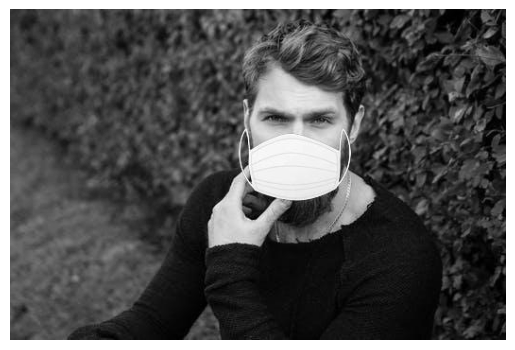

In [59]:
# Cargar la imagen en escala de grises
imagen = cv2.imread('test/mascarilla/0.jpg', cv2.IMREAD_GRAYSCALE)
# Mostrar imagen con OpenCV (requiere ventana emergente)
cv2.imshow('Imagen', imagen)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Mostrar con Matplotlib (evita problemas con colores)
plt.imshow(imagen, cmap='gray')
plt.axis('off')
plt.show()

In [44]:
dim = (128, 128) #Tamaño típico para modelos como VGG16 o ResNet
imagen_redimensionada = cv2.resize(imagen, dim, interpolation=cv2.INTER_AREA)

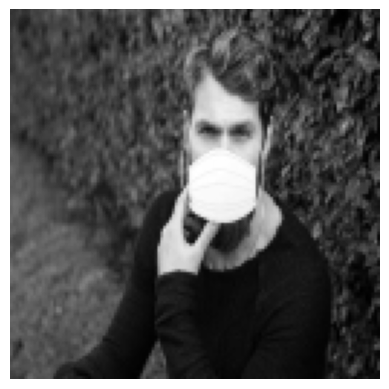

In [45]:
plt.imshow(imagen_redimensionada, cmap='gray')
plt.axis('off')
plt.show()

In [46]:
imagen_normalizada = imagen_redimensionada / 255.0
imagen_ecualizada = cv2.equalizeHist(imagen_redimensionada)

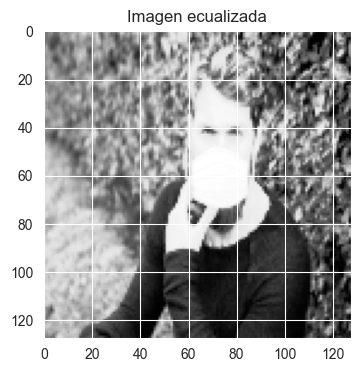

In [47]:
plt.figure(figsize=(12, 4))
plt.imshow(imagen_ecualizada, cmap='gray')
plt.title('Imagen ecualizada')
plt.show()

In [48]:
# Filtro Gaussiano
imagen_suavizada = cv2.GaussianBlur(imagen_ecualizada, (5,5), 0)
# Filtro de mediana
imagen_median = cv2.medianBlur(imagen_suavizada, 5)

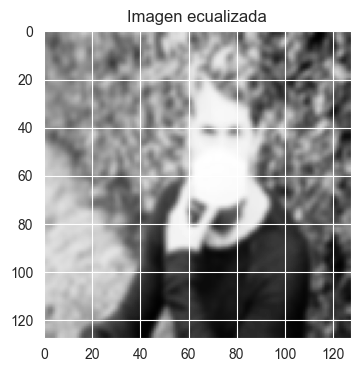

In [49]:
plt.figure(figsize=(12, 4))
plt.imshow(imagen_suavizada, cmap='gray')
plt.title('Imagen ecualizada')
plt.show()

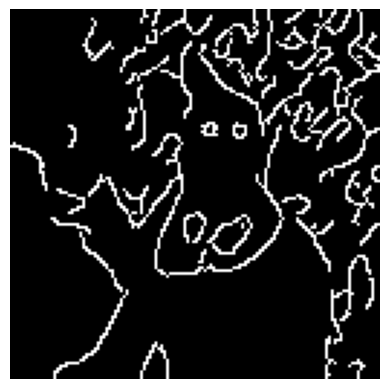

In [50]:
bordes = cv2.Canny(imagen_median, 100, 200)
plt.imshow(bordes, cmap='gray')
plt.axis('off')
plt.show()

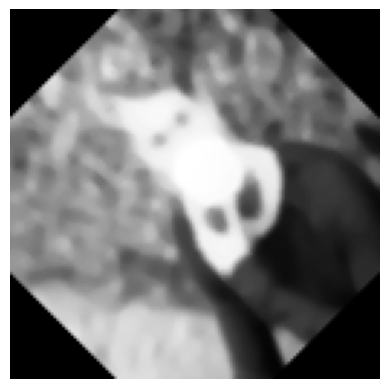

In [51]:
# Rotación de 45 grados alrededor del centro
(h, w) = imagen_median.shape[:2]
M = cv2.getRotationMatrix2D((w//2, h//2), 45, 1.0)
imagen_rotada = cv2.warpAffine(imagen_median, M, (w, h))
plt.imshow(imagen_rotada, cmap='gray')
plt.axis('off')
plt.show()

## 4. Entrenamiento del modelo

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model = keras.Sequential([
 Input(shape=(128, 128, 3)),

 Conv2D(32, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(64, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(128, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Flatten(),
 Dense(64, activation='relu'),
 Dropout(0.3),
 Dense(32, activation='relu'),
 Dense(1, activation='sigmoid')  # Solo una neurona para clasificación binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,701,057 (6.49 MB)

 Trainable params: 1,701,057 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
epochs = 20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=32)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.4305 - loss: 19.5079 - val_accuracy: 0.5649 - val_loss: 0.6392
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.7294 - loss: 0.5104 - val_accuracy: 0.8931 - val_loss: 0.3014
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.8518 - loss: 0.3369 - val_accuracy: 0.9160 - val_loss: 0.3252
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.9066 - loss: 0.1983 - val_accuracy: 0.9160 - val_loss: 0.2740
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.9356 - loss: 0.1649 - val_accuracy: 0.9008 - val_loss: 0.3509
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.9605 - loss: 0.1225 - val_accuracy: 0.9466 - val_loss: 0.2644
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.9701 - loss: 0.0941 - val_accuracy: 0.9542 - val_loss: 0.2325
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - accuracy: 0.9949 - loss: 0.0393 - val_accuracy: 0

### 5. Visualización de rendimiento del modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7510 - loss: 0.6769
Pérdida en test: 0.6774
Precisión en test: 0.7375


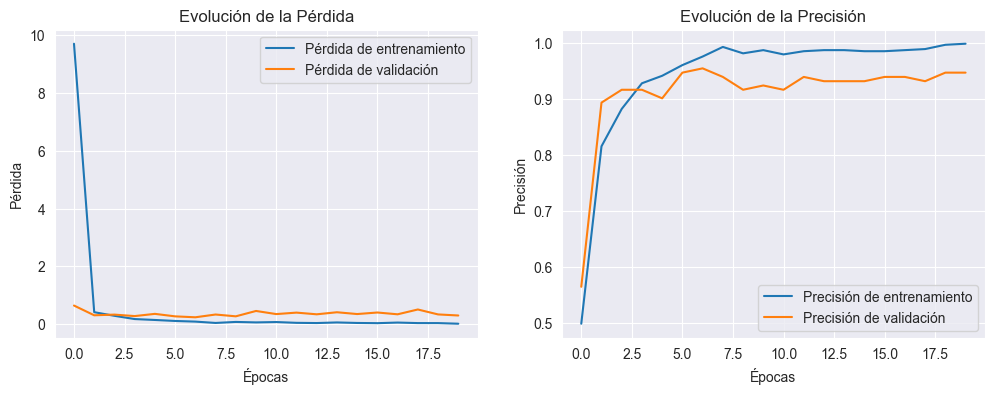

In [54]:
# Evaluación del modelo en el conjunto de test
loss, accuracy = model.evaluate(test_Y)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")
# Visualización de la evolución del entrenamiento
# Extraer los valores del historial
epochs_range = range(epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')
plt.show()


### 6. Uso del modelo en predicciones

In [55]:
# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(test_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Verificar las formas
# print(f"test_Y shape: {test_dataset.shape}")  # Usar labels en test_dataset
print(f"predicted_classes shape: {predicted_classes.shape}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
predicted_classes shape: (160,)


In [56]:
target_names = ["mascarilla", "no_mascarilla"]

# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(test_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Obtener las etiquetas reales
true_labels = []
for _, labels in test_dataset:
    true_labels.append(labels)
true_labels = np.concatenate(true_labels)  # Convertir a array de NumPy

# Verificar las formas
print(f"true_labels shape: {true_labels.shape}")
print(f"predicted_classes shape: {predicted_classes.shape}")

# Mostrar el classification_report
print(classification_report(true_labels, predicted_classes, target_names=target_names))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
true_labels shape: (160, 1)
predicted_classes shape: (160,)
               precision    recall  f1-score   support

   mascarilla       0.50      0.47      0.49        80
no_mascarilla       0.50      0.53      0.51        80

     accuracy                           0.50       160
    macro avg       0.50      0.50      0.50       160
 weighted avg       0.50      0.50      0.50       160



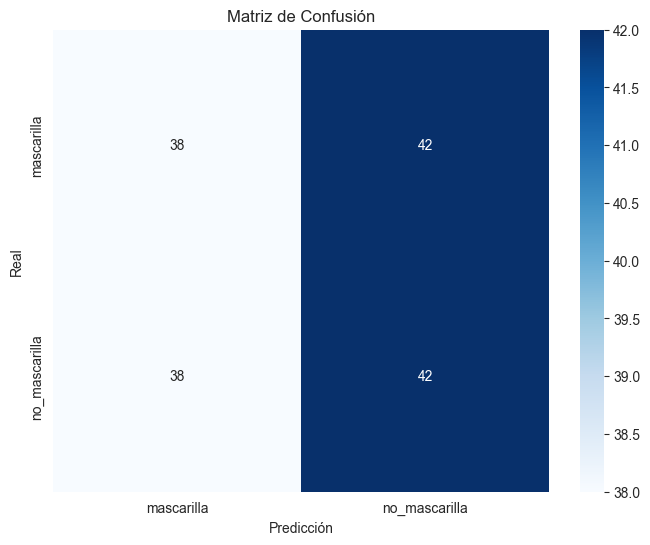

In [57]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Etiquetas correctas para las 10 clases
target_names = ["mascarilla", "no_mascarilla"]

# Mostrar matriz de confusión con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()